In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf



In [2]:
def find_dates(sids,model_cal):

	dates = sids.apply(lambda row : cf.datetime(calendar=model_cal,
									year=row.year,
									month=row.month,
									day=row.day,
									hour=row.hour
									), axis=1)
	return dates



In [3]:
# load dataset
# load data
def generate_annual_frequency(meta,rain,units_converter):
	
	# get subset of storms
	# dates = meta.date
	boolean = meta.date != 0
	print(meta.date)

	meta = meta.loc[boolean]
	rain = rain[boolean ,:,:,:]
	new_boolean = np.mean(rain,axis=(1,2,3)) != 0
	print('bool',new_boolean.shape)
	meta = meta.loc[new_boolean]
	rain = rain[new_boolean,:,:,:]
	# dates_unique=dates.drop_duplicates()
	# ndates = len(dates_unique)
	print('number of timepoints = ', meta.shape)
	sids = meta.sid
	sids_unique = sids.drop_duplicates()
	# nsids = len(sids_unique)
	# meta.date = pd.to_datetime(meta.date)
	tracks_grouped = meta.groupby(meta.sid)
	# tracks_grouped = meta.groupby(pd.Grouper(freq='M'))
	# tracks_grouped = meta.resample(rule='M', on='date')
	print(tracks_grouped)
	# total_rain = np.zeros((ndates,100,100))
	# total_rain = np.zeros((ndates))
	# i=0
	# drop_idx=[]
	# south_idx=[]
	# north_idx=[]
	daily_rains = []
	# daily_dates = []
	
	# find time frequency
	print('sids unique',sids_unique.shape)
	# for sid in sids_unique:
	# 	print(sid)
	# 	# date_for_rain = tracks_grouped.get_group(date)
	# 	rain_sid = tracks_grouped.get_group(sid)

	# 	track_dates = rain_sid.date
	# 	for track_date in track_dates:
	# 		track_daily_rain = np.sum(rain[track_dates.index,:,:,0],axis=0)*units_converter
	# 		mean_track_daily_rain = np.mean(track_daily_rain)

	# 		daily_rains.append(mean_track_daily_rain)
	# 		daily_dates.append(track_date)

	for sample in rain:
		# print(sample.shape)
		# date_for_rain = tracks_grouped.get_group(date)

		track_daily_rain = np.mean(sample)*units_converter # for cmip this is 24, for imerg it should be 8
		# they multiplied by 4 i think
		# mean_track_daily_rain = np.mean(track_daily_rain)

		daily_rains.append(track_daily_rain)
		# daily_dates.append(track_date)


		# storm_rain = rain[rain_sid.index,:,:,0]
		# print('storm_rain shape',storm_rain.shape)

		# imerg is mm/hr sampled based on ibtracs which is 3 hourly positions
		units_converter_imerg = 3

		# mswep is total rain mm/3hr sampled based on ibtracs which is 3 hourly positions interpolated from 6 hourly
		units_converter_mswep = 1

		# cmip is mm/6hr sampled every 6 hours
		units_converter_cmip = 4


		
		# total_daily_rain = np.mean(storm_rain,axis=0)*units_converter
		
		

		# total_rain[i,:,:] = total_daily_rain
		# print('shape of total_daily_rain sum',np.mean(total_daily_rain))
		# total_rain[i] = np.mean(total_daily_rain)
		# i=i+1

	
	# # get nh and sh datasets
	# composite_storm_rain_nh = composite_storm_rain[north_idx,:,:]
	# composite_storm_rain_sh = composite_storm_rain[south_idx,:,:]
	x = np.arange(-5, 300, 5)
	y = np.histogram(daily_rains,bins = x)[0]

	print(y)
	window_size = 5
	smoothed_frequencies = np.convolve(y, np.ones(window_size) / window_size, mode='same')
	y = smoothed_frequencies
	y[0] = 1
	# y[y==0] = 1
	return y,x[1:]




In [4]:
def calc_nyears(meta):
	nyears = int(meta.year[len(meta.year)-1] - meta.year[0] + 1)
	return nyears

In [5]:
def lookup(row,cal):
	# date = cf.datetime(calendar=cal,
	# 				year=row.year,
	# 				month=row.month,
	# 				day=row.day,
	# 				hour=row.hour
	# 				)
	if row.year not in range(2000,2015):
		return 0
	else:
		date = cf.datetime(calendar=cal,
						year=row.year,
						month=row.month,
						day=row.day,
						)

	# date = pd.to_datetime('year' : row.year, 'month' : row.month, 'day' = row.day)
	return date

def lookup_ibtracs(row,tracks):
	# tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
	# 					usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
	# 					parse_dates = ['ISO_TIME'],keep_default_na=False)
	boolean = (tracks.SID == row.sid) & (tracks.LAT == row.centre_lat) & (tracks.LON == row.centre_lon)
	time =  pd.to_datetime(tracks.loc[boolean].ISO_TIME)
	if list(time) == []:
		print('no',flush=True)
		date = cf.datetime(calendar='gregorian',
						year=1978,
						month=1,
						day=1,
						hour=0
						)
		return date
	else:
		time =  time.iloc[0]
		date = cf.datetime(calendar='gregorian',
						year=time.year,
						month=time.month,
						day=time.day,
						)
	return date

def find_dates_mswep(meta):
	dates = meta.apply(lookup, axis=1)
	return dates

def find_dates(meta,calendar):
	dates = meta.apply(lookup, cal = calendar, axis=1)
	return dates

def find_dates_ibtracs(meta):
	tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
						usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
						parse_dates = ['ISO_TIME'],keep_default_na=False)
	dates = meta.apply(lookup_ibtracs, tracks= tracks, axis=1)
	# dates = meta.apply(lookup_ibtracs, axis=1)
	return dates

In [6]:
# load imerg
imerg_rain = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_rain_NH.npy')
imerg_lats = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_lats_NH.npy')
imerg_lons = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_lons_NH.npy')
imerg_sids = pd.read_csv('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_sid_NH.csv')
print(imerg_sids.sid.shape)
meta_imerg = pd.DataFrame({'sid':imerg_sids.sid ,'centre_lat':imerg_lats[:,4], 'centre_lon':imerg_lons[:,4],'date':find_dates(imerg_sids,calendar='julian')})

(22142,)


In [7]:
print(imerg_sids.sid.drop_duplicates())

0        2000170N10268
31       2000184N13133
68       2000185N15117
87       2000205N10260
130      2000214N22155
             ...      
22019    2020272N12257
22051    2020276N17277
22052    2020279N16284
22087    2020291N32305
22124    2020299N18277
Name: sid, Length: 816, dtype: object


In [8]:
import os

In [9]:
files = os.listdir('/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat')
print(files[0])

1979032.00.nc


In [10]:
# dir = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat'
# files = os.listdir(dir)
# print(len(files))

# years = range(1979,2022)
# doys = days_of_year = [str(day).zfill(3) for day in range(367)]
# times = ['00','03','06','09','12','15','18','21','24']
# files_accounted_for = []
# files_not_accounted_for = []

# for year in years:
#     for doy in doys:
#         for time in times:
#             file_name = f'{year}{doy}.{time}.nc'
#             if file_name in files:
#                 files_accounted_for.append(file_name)
#             else:
#                 files_not_accounted_for.append(file_name)


In [11]:
# print(len(files_accounted_for))
# print(len(files_not_accounted_for))

In [12]:
# print(files_not_accounted_for)
# # Save the list to a text file
# with open('file_list.txt', 'w') as f:
#     for item in files_not_accounted_for:
#         f.write("%s\n" % item)


In [13]:
# dir = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly'
# files = os.listdir(dir)
# print(len(files))

# years = range(1979,2022)
# doys = days_of_year = [str(day).zfill(3) for day in range(367)]
# times = ['00','03','06','09','12','15','18','21']
# files_accounted_for2 = []
# files_not_accounted_for2 = []

# for year in years:
#     for doy in doys:
#         for time in times:
#             file_name = f'{year}{doy}.{time}.nc'
#             if file_name in files:
#                 files_accounted_for2.append(file_name)
#             else:
#                 files_not_accounted_for2.append(file_name)

In [14]:
# print(len(files_accounted_for2))
# print(len(files_not_accounted_for2))
# with open('file_list.txt', 'w') as f:
#     for item in files_not_accounted_for2:
#         f.write("%s\n" % item)

In [15]:
tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
						usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
						parse_dates = ['ISO_TIME'],keep_default_na=False)

# tidy up columns with multiple dtypes
tracks = tracks.iloc[1: , :]
tracks = tracks.replace(' ', np.nan)
tracks['USA_SSHS'] = pd.to_numeric(tracks['USA_SSHS'])
tracks['SEASON'] = pd.to_numeric(tracks['SEASON'])

tracks = tracks[tracks['SEASON'] >= 2000]
tracks = tracks[tracks['SEASON'] <= 2014]
# tracks = tracks[tracks['SEASON'] == 2000]
print(tracks)
# tracks = tracks[tracks['ISO_TIME'].dt.dayofyear >= 153]
# tracks = tracks[tracks['ISO_TIME'].dt.dayofyear <= 158]
tracks = tracks[tracks['NATURE'] == 'TS']

TCs = tracks[tracks['USA_SSHS'] >= 0]['SID']
TCs = TCs.drop_duplicates()
print('number of TCs: ', len(TCs))
# reference tracks with TCs
tracks = pd.merge(tracks, 
                      TCs, 
                      on ='SID', 
                      how ='inner')
# tracks = tracks[tracks['USA_SSHS'] >= 1]
tracks = tracks[tracks['USA_SSHS'] >= 0]
print(tracks)

/tmp/ipykernel_20204/2102547868.py:1: DtypeWarning: Columns (1,8,9,25) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
/tmp/ipykernel_20204/2102547868.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',


                  SID  SEASON BASIN    NAME             ISO_TIME NATURE  \
566403  1999343S09095    2000    SI    ILSA  1999-12-08 22:00:00     NR   
566404  1999343S09095    2000    SI    ILSA  1999-12-09 00:00:00     NR   
566405  1999343S09095    2000    SI    ILSA  1999-12-09 03:00:00     NR   
566406  1999343S09095    2000    SI    ILSA  1999-12-09 06:00:00     NR   
566407  1999343S09095    2000    SI    ILSA  1999-12-09 09:00:00     NR   
...               ...     ...   ...     ...                  ...    ...   
658805  2014362N07130    2014    WP  JANGMI  2015-01-01 00:00:00     TS   
658806  2014362N07130    2014    WP  JANGMI  2015-01-01 03:00:00     TS   
658807  2014362N07130    2014    WP  JANGMI  2015-01-01 06:00:00     TS   
658808  2014362N07130    2014    WP  JANGMI  2015-01-01 09:00:00     TS   
658809  2014362N07130    2014    WP  JANGMI  2015-01-01 12:00:00     TS   

            LAT      LON  USA_SSHS  
566403     -9.0     95.0      -1.0  
566404 -9.02366  95.1764 

In [16]:
print(tracks.SID.drop_duplicates())

15       1999343S09095
114      1999343S11123
195      1999357S08076
287      2000003S13082
358      2000006S15164
             ...      
66497    2014303N13141
66550    2014309N13088
66582    2014329N08131
66607    2014334N02156
66704    2014362N07130
Name: SID, Length: 1254, dtype: object


In [17]:
print(imerg_sids.sid.drop_duplicates())
print(imerg_sids.sid.shape)

0        2000170N10268
31       2000184N13133
68       2000185N15117
87       2000205N10260
130      2000214N22155
             ...      
22019    2020272N12257
22051    2020276N17277
22052    2020279N16284
22087    2020291N32305
22124    2020299N18277
Name: sid, Length: 816, dtype: object
(22142,)


In [18]:
# load MSWEP
# load mswep
mswep_rain = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_rain_tcs_and_ts.npy')
mswep_lats = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_lats_tcs_and_ts.npy')
mswep_lons = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_lons_tcs_and_ts.npy')
mswep_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_sid_tcs_and_ts.csv')
print(mswep_sids.sid.shape)
idx = mswep_sids.year >= 2000
mswep_rain = mswep_rain[idx]
mswep_lats = mswep_lats[idx]
mswep_lons = mswep_lons[idx]
mswep_sids = mswep_sids[mswep_sids.year >= 2000].reset_index()
meta_mswep = pd.DataFrame({'sid':mswep_sids.sid ,'centre_lat':mswep_lats[:,4], 'centre_lon':mswep_lons[:,4],'date':find_dates(mswep_sids,calendar='standard')})


(43955,)


In [19]:
print(mswep_sids.sid.drop_duplicates())

0        1999357S08076
5        2000003S13082
58       2000006S15164
79       2000023S15172
109      2000024S12100
             ...      
43611    2014303N13141
43659    2014309N13088
43660    2014329N08131
43676    2014334N02156
43753    2014362N07130
Name: sid, Length: 1252, dtype: object


In [20]:
# imerg
# set imerg=True?
# i don't think we need to multiply rain by 3 hours maybe? because its rain rate over the hour so we assume it rains at the same rate for 3 or 6 hours depending on the track?
# I think the storm track is handling the fact its rain rate and not accumulated rainfall here.
# imerg_total_rain,imerg_dates = generate_annual_frequency(meta_imerg,np.expand_dims(imerg_rain,axis=-1),3)
# nyears_imerg = calc_nyears(meta_imerg)
total_rain_imerg,dates_imerg = generate_annual_frequency(meta_imerg,np.expand_dims(imerg_rain,axis=-1),24) # this might be 24 not 8
total_rain_mswep,dates_mswep = generate_annual_frequency(meta_mswep,np.expand_dims(mswep_rain,axis=-1),8)


0        2000-06-20 00:00:00
1        2000-06-20 00:00:00
2        2000-06-20 00:00:00
3        2000-06-20 00:00:00
4        2000-06-20 00:00:00
                ...         
22137                      0
22138                      0
22139                      0
22140                      0
22141                      0
Name: date, Length: 22142, dtype: object
bool (14553,)
number of timepoints =  (14427, 4)
sids unique (547,)
[   0  277 1051 1550 1676 1592 1620 1394 1149  909  746  612  437  338
  261  193  153  116   82   74   53   37   26   15   12    7   12    9
   10    6    3    3    2    0    1    0    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
0        2000-01-01 00:00:00
1        2000-01-01 00:00:00
2        2000-01-01 00:00:00
3        2000-01-01 00:00:00
4        2000-01-01 00:00:00
                ...         
43757    2014-12-29 00:00:00
43758    2014-12-29 00:00:00
43759    2014-12-29 00:00:00
43760

In [21]:

models = ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
for model in models:
    globals()[f'{model}_total_rain'] = np.load(f'/user/home/al18709/work/ke_track_rain/hr/{model}_rain_frequency.npy')
    globals()[f'{model}_dates'] = np.load(f'/user/home/al18709/work/ke_track_rain/hr/{model}_frequency_dates.npy')
    globals()[f'{model}_total_rain_qm'] = np.load(f'/user/home/al18709/work/ke_track_rain/hr/{model}_hist_rain_frequency_qm.npy')
    globals()[f'{model}_dates_qm'] = np.load(f'/user/home/al18709/work/ke_track_rain/hr/{model}_hist_frequency_dates_qm.npy')

In [22]:
# define cmap
precip_cmap,precip_norm = make_cmap()

In [23]:
print(canesm_total_rain.shape)

(60,)


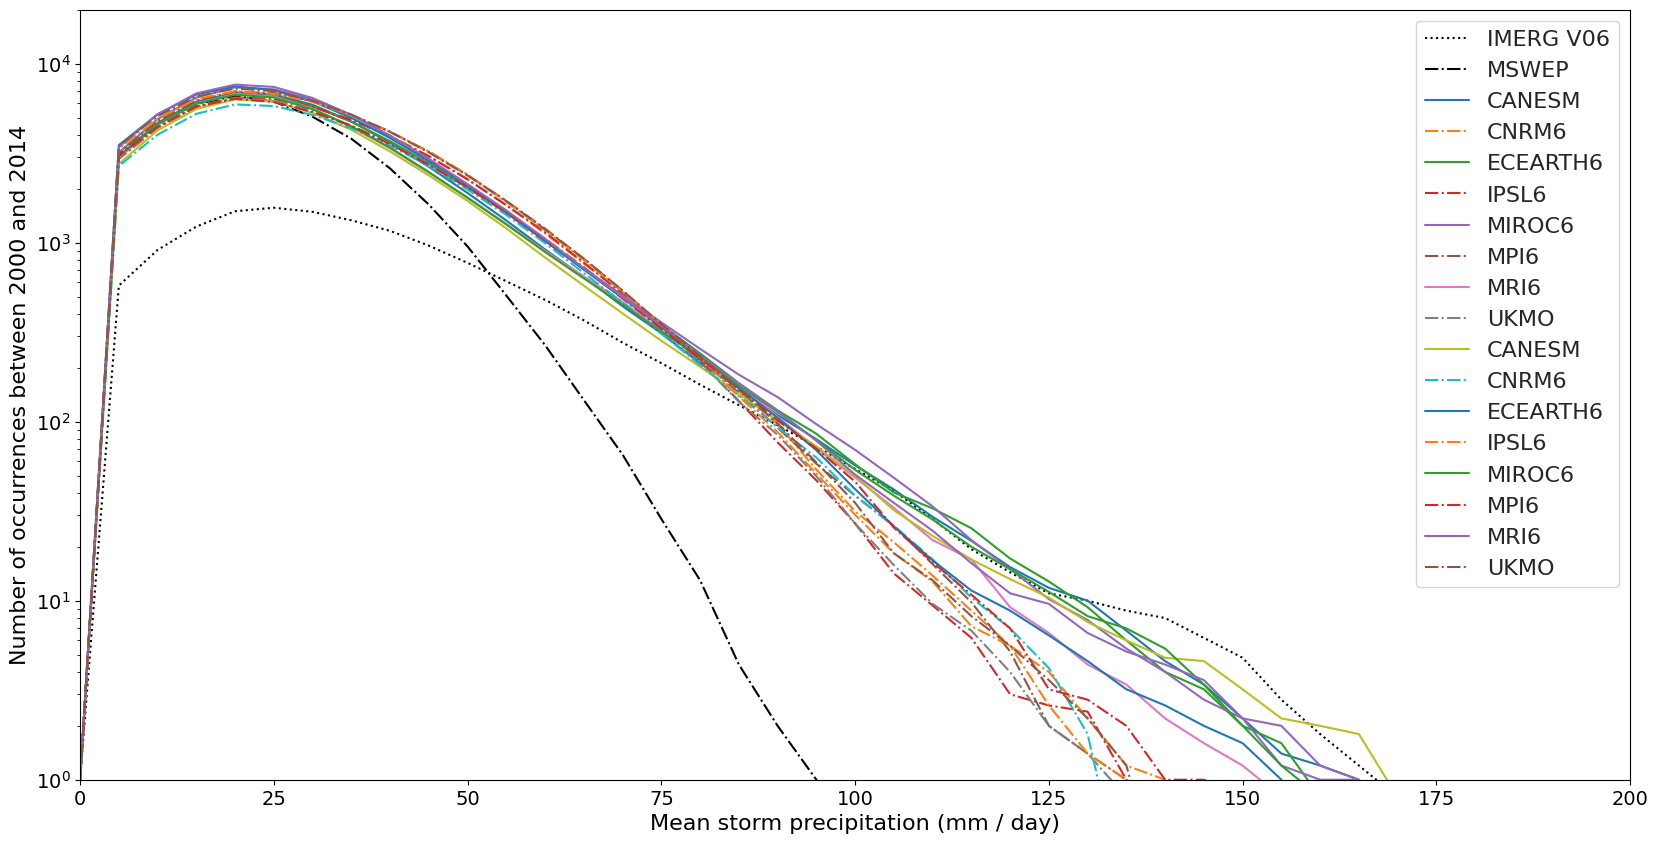

In [24]:
# TODO: subsample so all counts are equivalent to 6 hourly samples - it will skew results if mswep is 3 hourly and cmip6 is a mix of 3 and 6 hourly.
fig,axes = plt.subplots(1,1,figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("Set2")

# wgan
# plt.plot(dates_wgan,total_rain_wgan,linestyle='dashed')
# plt.plot(dates_wgan_og,total_rain_wgan_og,linestyle='dashed')

# IMERG Obs
plt.plot(dates_imerg,total_rain_imerg,color='black',linestyle='dotted')
plt.plot(dates_mswep,total_rain_mswep,color='black',linestyle='dashdot')


# chirps
for model in models:
    im = axes.plot(globals()[f'{model}_dates'],globals()[f'{model}_total_rain'])
    im = axes.plot(globals()[f'{model}_dates'],globals()[f'{model}_total_rain_qm'],linestyle='dashdot')



plt.yscale('log')
plt.ylim(1,20000)
plt.xlim(0,200)
plt.legend(['IMERG V06','MSWEP','CANESM','CNRM6','ECEARTH6','IPSL6', 'MIROC6','MPI6','MRI6','UKMO','CANESM','CNRM6','ECEARTH6','IPSL6', 'MIROC6','MPI6','MRI6','UKMO'],fontsize=16)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])
plt.xlabel('Mean storm precipitation (mm / day)',fontsize=16)
plt.ylabel('Number of occurrences between 2000 and 2014',fontsize=16)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])

plt.savefig('3_rain_frequency_hist.png',bbox_inches='tight')

In [25]:

models = ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
for model in models:
    globals()[f'{model}_total_rain_ssp585'] = np.load(f'/user/home/al18709/work/ke_track_rain/hr/{model}_ssp585_rain_frequency.npy')
    globals()[f'{model}_dates_ssp585'] = np.load(f'/user/home/al18709/work/ke_track_rain/hr/{model}_ssp585_frequency_dates.npy')
    globals()[f'{model}_total_rain_ssp585_qm'] = np.load(f'/user/home/al18709/work/ke_track_rain/hr/{model}_ssp585_rain_frequency_qm.npy')
    globals()[f'{model}_dates_ssp585_qm'] = np.load(f'/user/home/al18709/work/ke_track_rain/hr/{model}_ssp585_frequency_dates_qm.npy')

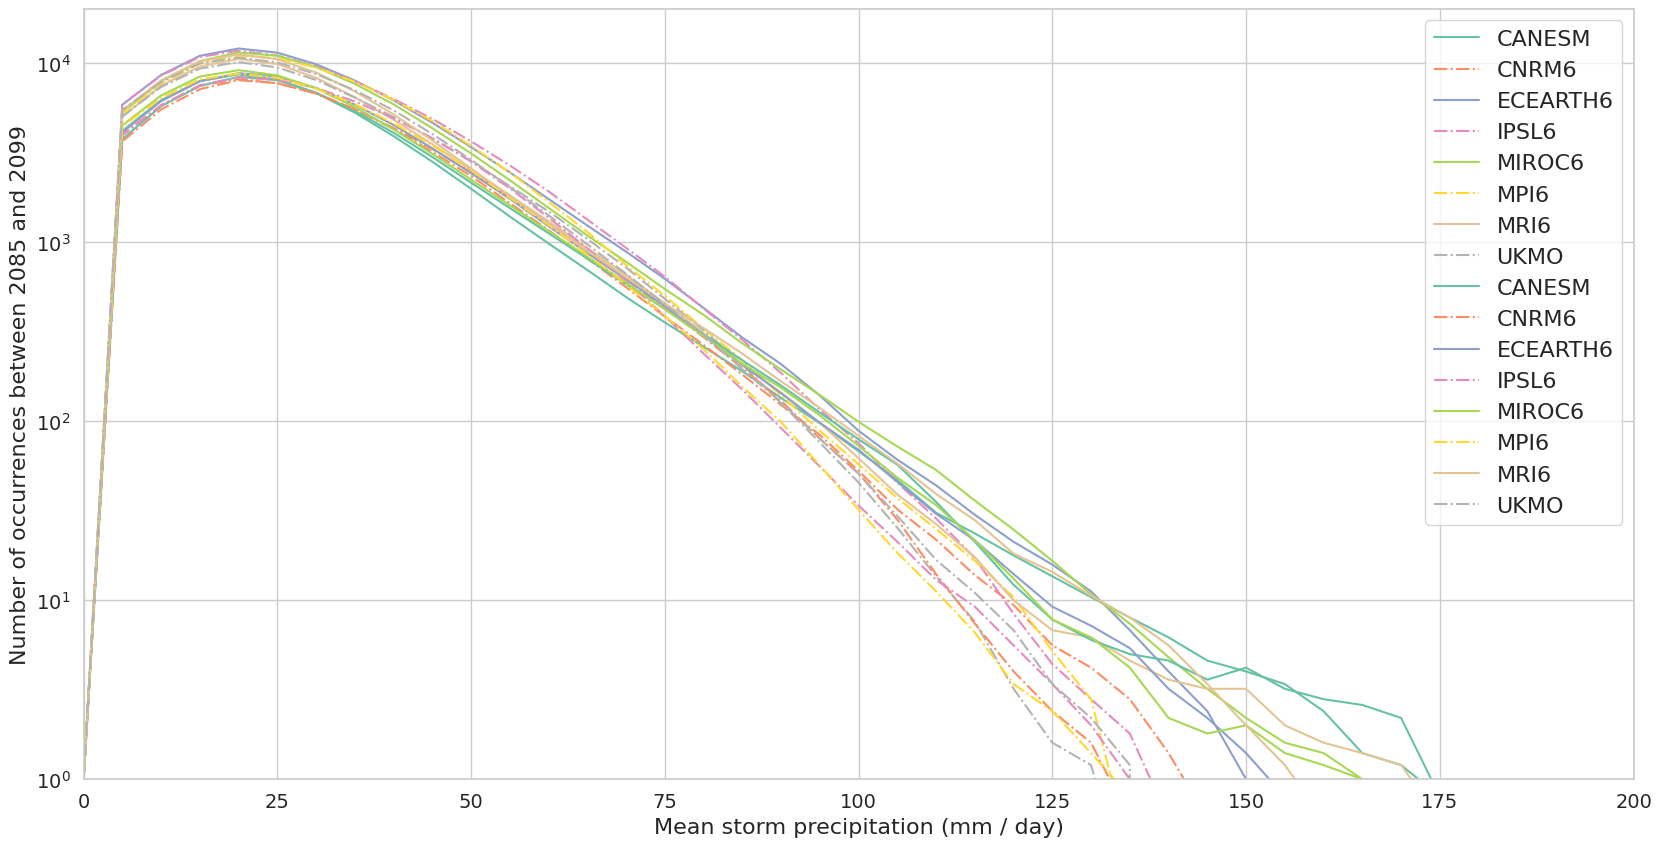

In [26]:
# TODO: subsample so all counts are equivalent to 6 hourly samples - it will skew results if mswep is 3 hourly and cmip6 is a mix of 3 and 6 hourly.
fig,axes = plt.subplots(1,1,figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("Set2")

# wgan
# plt.plot(dates_wgan,total_rain_wgan,linestyle='dashed')
# plt.plot(dates_wgan_og,total_rain_wgan_og,linestyle='dashed')

# IMERG Obs
# plt.plot(dates_imerg,total_rain_imerg,color='black',linestyle='dotted')
# plt.plot(dates_mswep,total_rain_mswep,color='black',linestyle='dashdot')


# chirps
for model in models:
    im = axes.plot(globals()[f'{model}_dates_ssp585'],globals()[f'{model}_total_rain_ssp585'])
    im = axes.plot(globals()[f'{model}_dates_ssp585'],globals()[f'{model}_total_rain_ssp585_qm'],linestyle='dashdot')



plt.yscale('log')
plt.ylim(1,20000)
plt.xlim(0,200)
plt.legend(['CANESM','CNRM6','ECEARTH6','IPSL6', 'MIROC6','MPI6','MRI6','UKMO','CANESM','CNRM6','ECEARTH6','IPSL6', 'MIROC6','MPI6','MRI6','UKMO'],fontsize=16)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])
plt.xlabel('Mean storm precipitation (mm / day)',fontsize=16)
plt.ylabel('Number of occurrences between 2085 and 2099',fontsize=16)

plt.savefig('3_rain_frequency_ssp585.png',bbox_inches='tight')

In [27]:
print(canesm_total_rain_ssp585.shape)

(60,)


In [28]:
# for model in models:
#     print(globals()[f'{model}_dates'])  
#     print(globals()[f'{model}_dates_ssp585'])


ssp585_ensemble_average_rain = np.mean(np.concatenate([np.expand_dims(canesm_total_rain_ssp585,axis=0),np.expand_dims(cnrm6_total_rain_ssp585,axis=0),np.expand_dims(miroc6_total_rain_ssp585,axis=0),np.expand_dims(ipsl6_total_rain_ssp585,axis=0),np.expand_dims(mri6_total_rain_ssp585,axis=0),np.expand_dims(mpi6_total_rain_ssp585,axis=0),np.expand_dims(ukmo_total_rain_ssp585,axis=0),np.expand_dims(ecearth6_total_rain_ssp585,axis=0)],axis=0),axis=0)
hist_ensemble_average_rain = np.mean(np.concatenate([np.expand_dims(canesm_total_rain,axis=0),np.expand_dims(cnrm6_total_rain,axis=0),np.expand_dims(miroc6_total_rain,axis=0),np.expand_dims(ipsl6_total_rain,axis=0),np.expand_dims(mri6_total_rain,axis=0),np.expand_dims(mpi6_total_rain,axis=0),np.expand_dims(ukmo_total_rain,axis=0),np.expand_dims(ecearth6_total_rain,axis=0)],axis=0),axis=0)
hist_ensemble_min_rain = np.min(np.concatenate([np.expand_dims(canesm_total_rain,axis=0),np.expand_dims(cnrm6_total_rain,axis=0),np.expand_dims(miroc6_total_rain,axis=0),np.expand_dims(ipsl6_total_rain,axis=0),np.expand_dims(mri6_total_rain,axis=0),np.expand_dims(mpi6_total_rain,axis=0),np.expand_dims(ukmo_total_rain,axis=0),np.expand_dims(ecearth6_total_rain,axis=0)],axis=0),axis=0)
hist_ensemble_max_rain = np.max(np.concatenate([np.expand_dims(canesm_total_rain,axis=0),np.expand_dims(cnrm6_total_rain,axis=0),np.expand_dims(miroc6_total_rain,axis=0),np.expand_dims(ipsl6_total_rain,axis=0),np.expand_dims(mri6_total_rain,axis=0),np.expand_dims(mpi6_total_rain,axis=0),np.expand_dims(ukmo_total_rain,axis=0),np.expand_dims(ecearth6_total_rain,axis=0)],axis=0),axis=0)


ssp585_ensemble_average_rain_qm = np.mean(np.concatenate([np.expand_dims(canesm_total_rain_ssp585_qm,axis=0),np.expand_dims(cnrm6_total_rain_ssp585_qm,axis=0),np.expand_dims(miroc6_total_rain_ssp585_qm,axis=0),np.expand_dims(ipsl6_total_rain_ssp585_qm,axis=0),np.expand_dims(mri6_total_rain_ssp585_qm,axis=0),np.expand_dims(mpi6_total_rain_ssp585_qm,axis=0),np.expand_dims(ukmo_total_rain_ssp585_qm,axis=0),np.expand_dims(ecearth6_total_rain_ssp585_qm,axis=0)],axis=0),axis=0)
hist_ensemble_average_rain_qm = np.mean(np.concatenate([np.expand_dims(canesm_total_rain_qm,axis=0),np.expand_dims(cnrm6_total_rain_qm,axis=0),np.expand_dims(miroc6_total_rain_qm,axis=0),np.expand_dims(ipsl6_total_rain_qm,axis=0),np.expand_dims(mri6_total_rain_qm,axis=0),np.expand_dims(mpi6_total_rain_qm,axis=0),np.expand_dims(ukmo_total_rain_qm,axis=0),np.expand_dims(ecearth6_total_rain_qm,axis=0)],axis=0),axis=0)
hist_ensemble_min_rain_qm = np.min(np.concatenate([np.expand_dims(canesm_total_rain_qm,axis=0),np.expand_dims(cnrm6_total_rain_qm,axis=0),np.expand_dims(miroc6_total_rain_qm,axis=0),np.expand_dims(ipsl6_total_rain_qm,axis=0),np.expand_dims(mri6_total_rain_qm,axis=0),np.expand_dims(mpi6_total_rain_qm,axis=0),np.expand_dims(ukmo_total_rain_qm,axis=0),np.expand_dims(ecearth6_total_rain_qm,axis=0)],axis=0),axis=0)
hist_ensemble_max_rain_qm = np.max(np.concatenate([np.expand_dims(canesm_total_rain_qm,axis=0),np.expand_dims(cnrm6_total_rain_qm,axis=0),np.expand_dims(miroc6_total_rain_qm,axis=0),np.expand_dims(ipsl6_total_rain_qm,axis=0),np.expand_dims(mri6_total_rain_qm,axis=0),np.expand_dims(mpi6_total_rain_qm,axis=0),np.expand_dims(ukmo_total_rain_qm,axis=0),np.expand_dims(ecearth6_total_rain_qm,axis=0)],axis=0),axis=0)
ssp585_ensemble_min_rain_qm = np.min(np.concatenate([np.expand_dims(canesm_total_rain_ssp585_qm,axis=0),np.expand_dims(cnrm6_total_rain_ssp585_qm,axis=0),np.expand_dims(miroc6_total_rain_ssp585_qm,axis=0),np.expand_dims(ipsl6_total_rain_ssp585_qm,axis=0),np.expand_dims(mri6_total_rain_ssp585_qm,axis=0),np.expand_dims(mpi6_total_rain_ssp585_qm,axis=0),np.expand_dims(ukmo_total_rain_ssp585_qm,axis=0),np.expand_dims(ecearth6_total_rain_ssp585_qm,axis=0)],axis=0),axis=0)
ssp585_ensemble_max_rain_qm = np.max(np.concatenate([np.expand_dims(canesm_total_rain_ssp585_qm,axis=0),np.expand_dims(cnrm6_total_rain_ssp585_qm,axis=0),np.expand_dims(miroc6_total_rain_ssp585_qm,axis=0),np.expand_dims(ipsl6_total_rain_ssp585_qm,axis=0),np.expand_dims(mri6_total_rain_ssp585_qm,axis=0),np.expand_dims(mpi6_total_rain_ssp585_qm,axis=0),np.expand_dims(ukmo_total_rain_ssp585_qm,axis=0),np.expand_dims(ecearth6_total_rain_ssp585_qm,axis=0)],axis=0),axis=0)
 

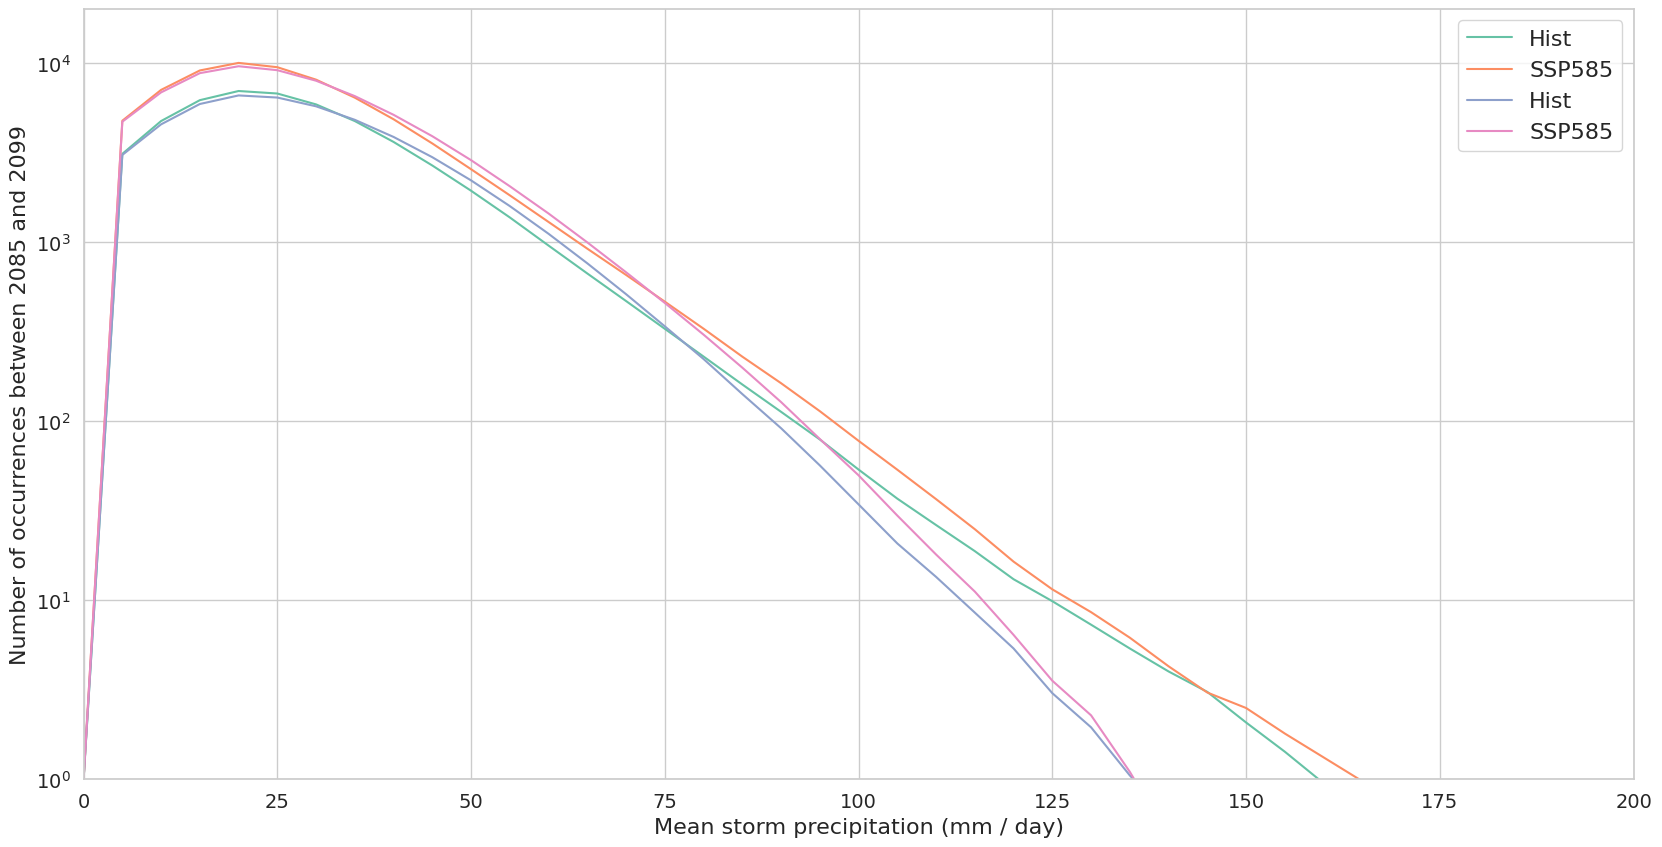

In [29]:
# TODO: subsample so all counts are equivalent to 6 hourly samples - it will skew results if mswep is 3 hourly and cmip6 is a mix of 3 and 6 hourly.
fig,axes = plt.subplots(1,1,figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("Set2")

# wgan
# plt.plot(dates_wgan,total_rain_wgan,linestyle='dashed')
# plt.plot(dates_wgan_og,total_rain_wgan_og,linestyle='dashed')

# IMERG Obs
# plt.plot(dates_imerg,total_rain_imerg,color='black',linestyle='dotted')
# plt.plot(dates_mswep,total_rain_mswep,color='black',linestyle='dashdot')


# chirps
axes.plot(cnrm6_dates,hist_ensemble_average_rain)
axes.plot(cnrm6_dates_ssp585,ssp585_ensemble_average_rain)
axes.plot(cnrm6_dates_qm,hist_ensemble_average_rain_qm)
axes.plot(cnrm6_dates_ssp585_qm,ssp585_ensemble_average_rain_qm)



plt.yscale('log')
plt.ylim(1,20000)
plt.xlim(0,200)
plt.legend(['Hist','SSP585','Hist','SSP585'],fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])
plt.xlabel('Mean storm precipitation (mm / day)',fontsize=16)
plt.ylabel('Number of occurrences between 2085 and 2099',fontsize=16)

plt.savefig('3_rain_frequency_ensemble_average.png',bbox_inches='tight')

# normalise to be per storm or per 10 storms

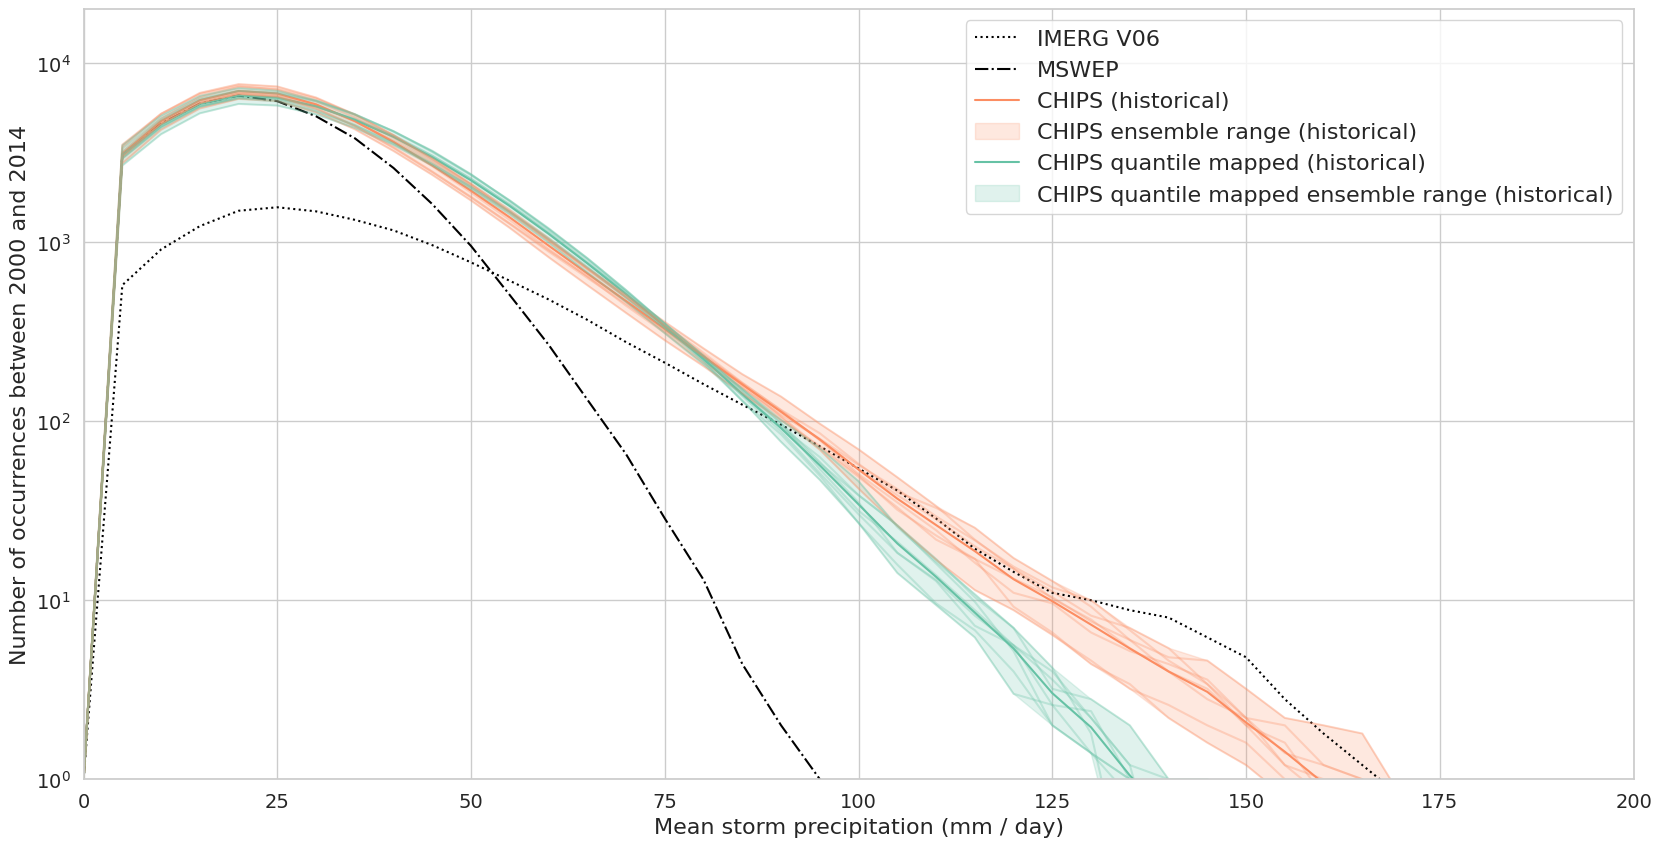

In [31]:
# TODO: subsample so all counts are equivalent to 6 hourly samples - it will skew results if mswep is 3 hourly and cmip6 is a mix of 3 and 6 hourly.
fig,axes = plt.subplots(1,1,figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("Set2")
colours = plt.cm.Set2(np.linspace(0, 1, 8))
# wgan
# plt.plot(dates_wgan,total_rain_wgan,linestyle='dashed')
# plt.plot(dates_wgan_og,total_rain_wgan_og,linestyle='dashed')

# IMERG Obs
plt.plot(dates_imerg,total_rain_imerg,color='black',linestyle='dotted')
plt.plot(dates_mswep,total_rain_mswep,color='black',linestyle='dashdot')
plt.plot(cnrm6_dates,hist_ensemble_average_rain,color=colours[1])
plt.fill_between(cnrm6_dates,hist_ensemble_min_rain,hist_ensemble_max_rain,alpha=0.2,color=colours[1])

plt.plot(cnrm6_dates_qm,hist_ensemble_average_rain_qm,color=colours[0])
plt.fill_between(cnrm6_dates_qm,hist_ensemble_min_rain_qm,hist_ensemble_max_rain_qm,alpha=0.2,color=colours[0])

# plt.plot(CMCC_dates,hist_highresmip_average_rain,linestyle='dashdot',color=colours[3])
# plt.fill_between(CMCC_dates,hist_highresmip_min_rain,hist_highresmip_max_rain,alpha=0.2,color=colours[3])

# plt.plot(mri_dates,hist_cmip6_average_rain,linestyle='dashdot',color=colours[4])
# plt.fill_between(mri_dates,hist_cmip6_min_rain,hist_cmip6_max_rain,alpha=0.2,color=colours[4])


# chirps
for model in models:
    im = axes.plot(globals()[f'{model}_dates'],globals()[f'{model}_total_rain'],alpha=0.3,color=colours[1])
    im = axes.plot(globals()[f'{model}_dates_qm'],globals()[f'{model}_total_rain_qm'],alpha=0.3,color=colours[0])

# for model in models2:
#     im = axes.plot(globals()[f'{model}_dates'],globals()[f'{model}_total_rain'],alpha=0.2,color=colours[3])
# for model in models3:
#     im = axes.plot(globals()[f'{model}_dates'],globals()[f'{model}_total_rain'],alpha=0.2,color=colours[4])

plt.yscale('log')
plt.ylim(1,20000)
plt.xlim(0,200)
plt.legend(['IMERG V06','MSWEP','CHIPS (historical)','CHIPS ensemble range (historical)','CHIPS quantile mapped (historical)','CHIPS quantile mapped ensemble range (historical)'],fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])
plt.xlabel('Mean storm precipitation (mm / day)',fontsize=16)
plt.ylabel('Number of occurrences between 2000 and 2014',fontsize=16)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])

plt.savefig('3_rain_frequency_hist.png',bbox_inches='tight')

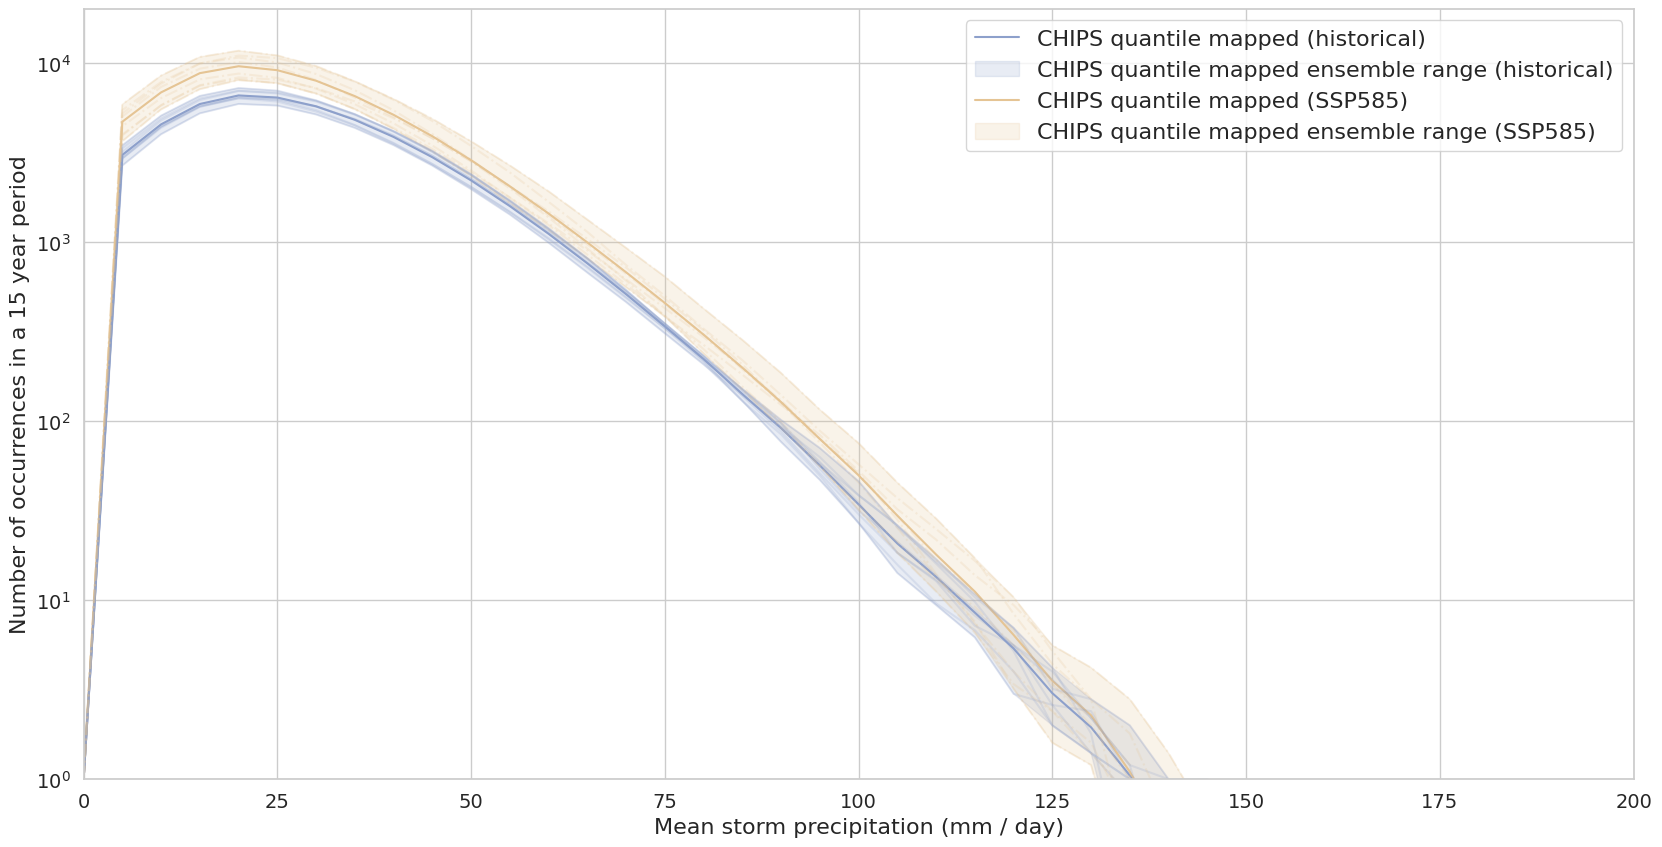

In [32]:
# TODO: subsample so all counts are equivalent to 6 hourly samples - it will skew results if mswep is 3 hourly and cmip6 is a mix of 3 and 6 hourly.
fig,axes = plt.subplots(1,1,figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("Set2")
colours = plt.cm.Set2(np.linspace(0, 1, 8))

# chirps
# axes.plot(cnrm6_dates,hist_ensemble_average_rain)
# axes.plot(cnrm6_dates_ssp585,ssp585_ensemble_average_rain)

plt.plot(cnrm6_dates_qm,hist_ensemble_average_rain_qm,color=colours[2])
plt.fill_between(cnrm6_dates_qm,hist_ensemble_min_rain_qm,hist_ensemble_max_rain_qm,alpha=0.2,color=colours[2])

plt.plot(cnrm6_dates_ssp585_qm,ssp585_ensemble_average_rain_qm,color=colours[6])
plt.fill_between(cnrm6_dates_qm,ssp585_ensemble_min_rain_qm,ssp585_ensemble_max_rain_qm,alpha=0.2,color=colours[6])

# chirps
for model in models:
    im = axes.plot(globals()[f'{model}_dates_qm'],globals()[f'{model}_total_rain_qm'],alpha=0.2,color=colours[2])
    im = axes.plot(globals()[f'{model}_dates_ssp585_qm'],globals()[f'{model}_total_rain_ssp585_qm'],linestyle='dashdot',alpha=0.2,color=colours[6])


plt.yscale('log')
plt.ylim(1,20000)
plt.xlim(0,200)
plt.legend(['CHIPS quantile mapped (historical)','CHIPS quantile mapped ensemble range (historical)','CHIPS quantile mapped (SSP585)','CHIPS quantile mapped ensemble range (SSP585)'],fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])
plt.xlabel('Mean storm precipitation (mm / day)',fontsize=16)
plt.ylabel('Number of occurrences in a 15 year period',fontsize=16)

plt.savefig('3_rain_frequency_ensemble_average.png',bbox_inches='tight')

# normalise to be per storm or per 10 storms

In [35]:
models2 = ['CMCC','hadgem']
for model in models2:
    globals()[f'{model}_dates'] = np.load(f'data/dates_{model}.npy')
    globals()[f'{model}_dates_ssp585'] = np.load(f'data/dates_{model}_ssp585.npy')
    globals()[f'{model}_total_rain'] = np.load(f'data/total_rain_{model}.npy')
    globals()[f'{model}_total_rain_ssp585'] = np.load(f'data/total_rain_{model}_ssp585.npy')


ssp585_highresmip_average_rain = np.mean(np.concatenate([np.expand_dims(CMCC_total_rain_ssp585,axis=0),np.expand_dims(hadgem_total_rain_ssp585,axis=0)],axis=0),axis=0)
ssp585_highresmip_min_rain = np.min(np.concatenate([np.expand_dims(CMCC_total_rain_ssp585,axis=0),np.expand_dims(hadgem_total_rain_ssp585,axis=0)],axis=0),axis=0)
ssp585_highresmip_max_rain = np.max(np.concatenate([np.expand_dims(CMCC_total_rain_ssp585,axis=0),np.expand_dims(hadgem_total_rain_ssp585,axis=0)],axis=0),axis=0)

hist_highresmip_average_rain = np.mean(np.concatenate([np.expand_dims(CMCC_total_rain,axis=0),np.expand_dims(hadgem_total_rain,axis=0)],axis=0),axis=0)
hist_highresmip_min_rain = np.min(np.concatenate([np.expand_dims(CMCC_total_rain,axis=0),np.expand_dims(hadgem_total_rain,axis=0)],axis=0),axis=0)
hist_highresmip_max_rain = np.max(np.concatenate([np.expand_dims(CMCC_total_rain,axis=0),np.expand_dims(hadgem_total_rain,axis=0)],axis=0),axis=0)


models3 = ['cmcclr','ecearth','ipsl','miroc6','mpi','mri','nesm','noresm']
for model in models3:
    globals()[f'{model}_dates'] = np.load(f'data/dates_{model}.npy')
    globals()[f'{model}_dates_ssp585'] = np.load(f'data/dates_{model}_ssp585.npy')
    globals()[f'{model}_total_rain'] = np.load(f'data/total_rain_{model}.npy')
    globals()[f'{model}_total_rain_ssp585'] = np.load(f'data/total_rain_{model}_ssp585.npy')

ssp585_cmip6_average_rain = np.mean(np.concatenate([np.expand_dims(cmcclr_total_rain_ssp585,axis=0),np.expand_dims(ecearth_total_rain_ssp585,axis=0),np.expand_dims(ipsl_total_rain_ssp585,axis=0),np.expand_dims(miroc6_total_rain_ssp585,axis=0),np.expand_dims(mpi_total_rain_ssp585,axis=0),np.expand_dims(mri_total_rain_ssp585,axis=0),np.expand_dims(nesm_total_rain_ssp585,axis=0),np.expand_dims(noresm_total_rain_ssp585,axis=0)],axis=0),axis=0)
ssp585_cmip6_min_rain = np.min(np.concatenate([np.expand_dims(cmcclr_total_rain_ssp585,axis=0),np.expand_dims(ecearth_total_rain_ssp585,axis=0),np.expand_dims(ipsl_total_rain_ssp585,axis=0),np.expand_dims(miroc6_total_rain_ssp585,axis=0),np.expand_dims(mpi_total_rain_ssp585,axis=0),np.expand_dims(mri_total_rain_ssp585,axis=0),np.expand_dims(nesm_total_rain_ssp585,axis=0),np.expand_dims(noresm_total_rain_ssp585,axis=0)],axis=0),axis=0)
ssp585_cmip6_max_rain = np.max(np.concatenate([np.expand_dims(cmcclr_total_rain_ssp585,axis=0),np.expand_dims(ecearth_total_rain_ssp585,axis=0),np.expand_dims(ipsl_total_rain_ssp585,axis=0),np.expand_dims(miroc6_total_rain_ssp585,axis=0),np.expand_dims(mpi_total_rain_ssp585,axis=0),np.expand_dims(mri_total_rain_ssp585,axis=0),np.expand_dims(nesm_total_rain_ssp585,axis=0),np.expand_dims(noresm_total_rain_ssp585,axis=0)],axis=0),axis=0)

hist_cmip6_average_rain = np.mean(np.concatenate([np.expand_dims(cmcclr_total_rain,axis=0),np.expand_dims(ecearth_total_rain,axis=0),np.expand_dims(ipsl_total_rain,axis=0),np.expand_dims(miroc6_total_rain,axis=0),np.expand_dims(mpi_total_rain,axis=0),np.expand_dims(mri_total_rain,axis=0),np.expand_dims(nesm_total_rain,axis=0),np.expand_dims(noresm_total_rain,axis=0)],axis=0),axis=0)
hist_cmip6_min_rain = np.min(np.concatenate([np.expand_dims(cmcclr_total_rain,axis=0),np.expand_dims(ecearth_total_rain,axis=0),np.expand_dims(ipsl_total_rain,axis=0),np.expand_dims(miroc6_total_rain,axis=0),np.expand_dims(mpi_total_rain,axis=0),np.expand_dims(mri_total_rain,axis=0),np.expand_dims(nesm_total_rain,axis=0),np.expand_dims(noresm_total_rain,axis=0)],axis=0),axis=0)
hist_cmip6_max_rain = np.max(np.concatenate([np.expand_dims(cmcclr_total_rain,axis=0),np.expand_dims(ecearth_total_rain,axis=0),np.expand_dims(ipsl_total_rain,axis=0),np.expand_dims(miroc6_total_rain,axis=0),np.expand_dims(mpi_total_rain,axis=0),np.expand_dims(mri_total_rain,axis=0),np.expand_dims(nesm_total_rain,axis=0),np.expand_dims(noresm_total_rain,axis=0)],axis=0),axis=0)

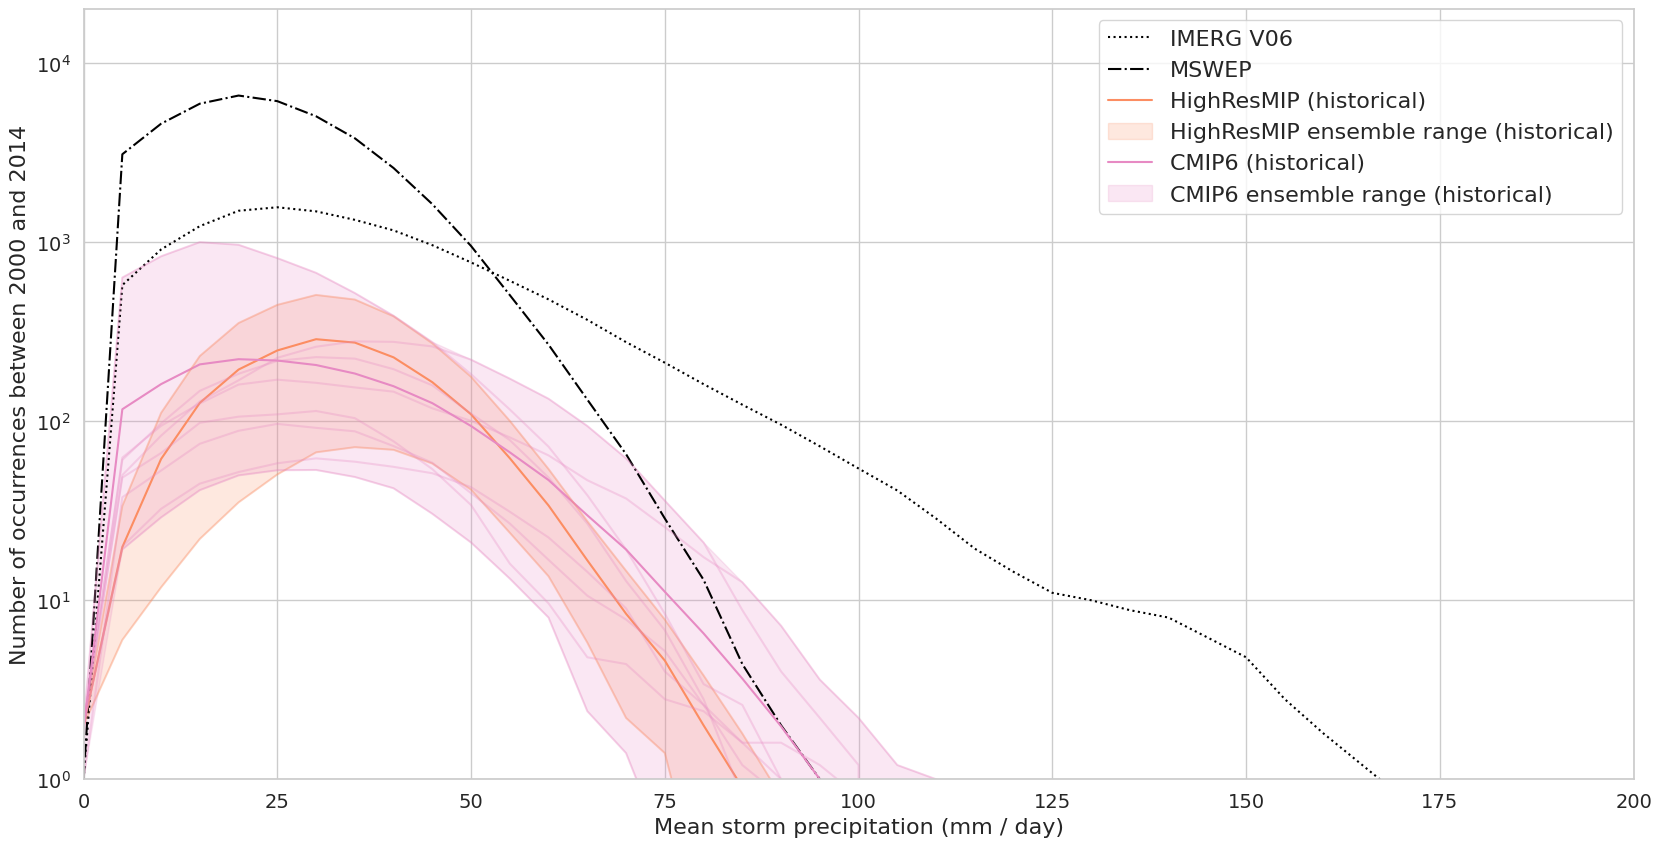

In [38]:
# TODO: subsample so all counts are equivalent to 6 hourly samples - it will skew results if mswep is 3 hourly and cmip6 is a mix of 3 and 6 hourly.
fig,axes = plt.subplots(1,1,figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("Set2")
colours = plt.cm.Set2(np.linspace(0, 1, 8))
# wgan
# plt.plot(dates_wgan,total_rain_wgan,linestyle='dashed')
# plt.plot(dates_wgan_og,total_rain_wgan_og,linestyle='dashed')

# IMERG Obs
plt.plot(dates_imerg,total_rain_imerg,color='black',linestyle='dotted')
plt.plot(dates_mswep,total_rain_mswep,color='black',linestyle='dashdot')

plt.plot(CMCC_dates,hist_highresmip_average_rain,color=colours[1])
plt.fill_between(CMCC_dates,hist_highresmip_min_rain,hist_highresmip_max_rain,alpha=0.2,color=colours[1])

plt.plot(mri_dates,hist_cmip6_average_rain,color=colours[3])
plt.fill_between(mri_dates,hist_cmip6_min_rain,hist_cmip6_max_rain,alpha=0.2,color=colours[3])

# plt.plot(CMCC_dates_ssp585,ssp585_highresmip_average_rain,color=colours[1],linestyle='dashed')
# plt.fill_between(CMCC_dates_ssp585,ssp585_highresmip_min_rain,ssp585_highresmip_max_rain,alpha=0.2,color=colours[1])

# plt.plot(mri_dates_ssp585,ssp585_cmip6_average_rain,color=colours[3],linestyle='dashed')
# plt.fill_between(mri_dates_ssp585,ssp585_cmip6_min_rain,ssp585_cmip6_max_rain,alpha=0.2,color=colours[3])

# chirps
for model in models2:
    im = axes.plot(globals()[f'{model}_dates'],globals()[f'{model}_total_rain'],alpha=0.3,color=colours[1])
    # im = axes.plot(globals()[f'{model}_dates_ssp585'],globals()[f'{model}_total_rain_ssp585'],alpha=0.3,color=colours[1],linestyle='dashed')
for model in models3:
    im = axes.plot(globals()[f'{model}_dates'],globals()[f'{model}_total_rain'],alpha=0.3,color=colours[3])
    # im = axes.plot(globals()[f'{model}_dates_ssp585'],globals()[f'{model}_total_rain_ssp585'],alpha=0.3,color=colours[3],linestyle='dashed')

plt.yscale('log')
plt.ylim(1,20000)
plt.xlim(0,200)
plt.legend(['IMERG V06','MSWEP','HighResMIP (historical)','HighResMIP ensemble range (historical)','CMIP6 (historical)','CMIP6 ensemble range (historical)'],fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])
plt.xlabel('Mean storm precipitation (mm / day)',fontsize=16)
plt.ylabel('Number of occurrences between 2000 and 2014',fontsize=16)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])

plt.savefig('3_rain_frequency_highresmipandcmip6.png',bbox_inches='tight')

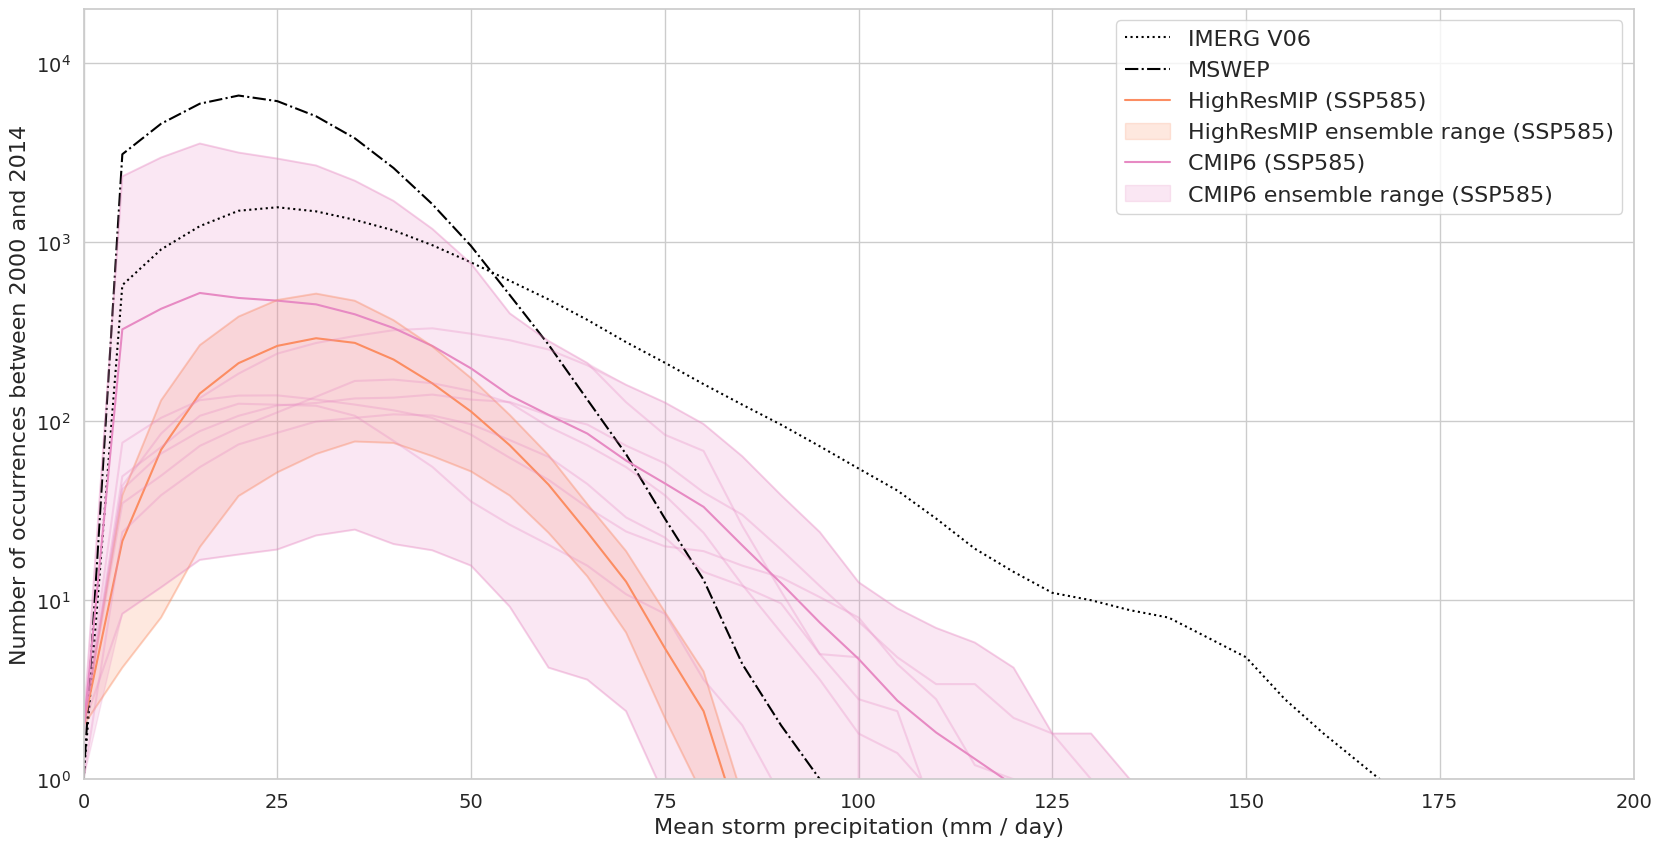

In [41]:
# TODO: subsample so all counts are equivalent to 6 hourly samples - it will skew results if mswep is 3 hourly and cmip6 is a mix of 3 and 6 hourly.
fig,axes = plt.subplots(1,1,figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("Set2")
colours = plt.cm.Set2(np.linspace(0, 1, 8))
# wgan
# plt.plot(dates_wgan,total_rain_wgan,linestyle='dashed')
# plt.plot(dates_wgan_og,total_rain_wgan_og,linestyle='dashed')

# IMERG Obs
plt.plot(dates_imerg,total_rain_imerg,color='black',linestyle='dotted')
plt.plot(dates_mswep,total_rain_mswep,color='black',linestyle='dashdot')

# plt.plot(CMCC_dates,hist_highresmip_average_rain,color=colours[1])
# plt.fill_between(CMCC_dates,hist_highresmip_min_rain,hist_highresmip_max_rain,alpha=0.2,color=colours[1])

# plt.plot(mri_dates,hist_cmip6_average_rain,color=colours[3])
# plt.fill_between(mri_dates,hist_cmip6_min_rain,hist_cmip6_max_rain,alpha=0.2,color=colours[3])

plt.plot(CMCC_dates_ssp585,ssp585_highresmip_average_rain,color=colours[1])
plt.fill_between(CMCC_dates_ssp585,ssp585_highresmip_min_rain,ssp585_highresmip_max_rain,alpha=0.2,color=colours[1])

plt.plot(mri_dates_ssp585,ssp585_cmip6_average_rain,color=colours[3])
plt.fill_between(mri_dates_ssp585,ssp585_cmip6_min_rain,ssp585_cmip6_max_rain,alpha=0.2,color=colours[3])

# chirps
for model in models2:
    # im = axes.plot(globals()[f'{model}_dates'],globals()[f'{model}_total_rain'],alpha=0.3,color=colours[1])
    im = axes.plot(globals()[f'{model}_dates_ssp585'],globals()[f'{model}_total_rain_ssp585'],alpha=0.3,color=colours[1])
for model in models3:
    # im = axes.plot(globals()[f'{model}_dates'],globals()[f'{model}_total_rain'],alpha=0.3,color=colours[3])
    im = axes.plot(globals()[f'{model}_dates_ssp585'],globals()[f'{model}_total_rain_ssp585'],alpha=0.3,color=colours[3])

plt.yscale('log')
plt.ylim(1,20000)
plt.xlim(0,200)
plt.legend(['IMERG V06','MSWEP','HighResMIP (SSP585)','HighResMIP ensemble range (SSP585)','CMIP6 (SSP585)','CMIP6 ensemble range (SSP585)'],fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])
plt.xlabel('Mean storm precipitation (mm / day)',fontsize=16)
plt.ylabel('Number of occurrences between 2000 and 2014',fontsize=16)
# plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])

plt.savefig('3_rain_frequency_highresmipandcmip6_future.png',bbox_inches='tight')